In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from empiricaldist import Pmf

In [4]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [5]:
# We start with re-examining the World Cup problem
# How we solved it with grid approximation

from scipy.stats import gamma

In [6]:
alpha = 1.4
prior_dist = gamma(alpha)

lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams[0], lams[-1])

In [7]:
from scipy.stats import poisson

In [8]:
data = 4
likelihood = poisson.pmf(data, lams)

posterior = prior_pmf * likelihood
posterior.normalize()

0.05015532557804499

In [9]:
# We can create a prior predictive distribution, which is similar to a posterior predictive except it uses the prior
# This can help confirm that our model of the prior is reasonable

sample_prior = prior_dist.rvs(1000)

sample_prior_pred = poisson.rvs(sample_prior)

pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

Text(0.5, 1.0, 'Prior predictive distribution')

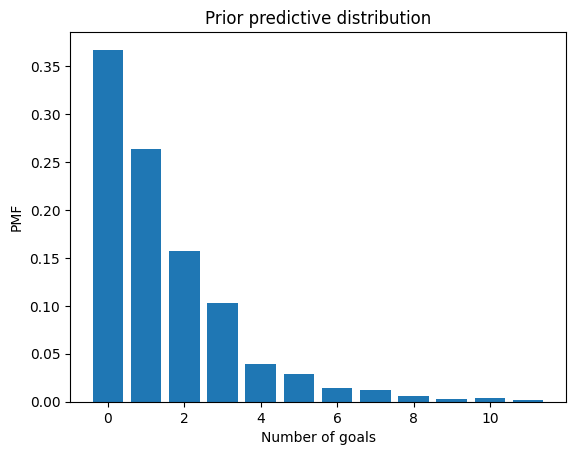

In [10]:
pmf_prior_pred.bar()
plt.xlabel('Number of goals')
plt.ylabel('PMF')
plt.title('Prior predictive distribution')

In [11]:
# The prior predictive distribution is a first step to using MCMC

In [11]:
import pymc as pm # holy crap, go with the web version of the text rather than the book. Wasted a day importing the wrong mcmc package

In [12]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

In [15]:
import graphviz

In [17]:
from pymc import model_to_graphviz

In [18]:
pm.model_to_graphviz(model) # This throws an error

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [19]:
# We can use pymc to sample from the prior and prior predictive distributions

with model:
    idata = pm.sample_prior_predictive(1000)

Sampling: [goals, lam]


In [20]:
type(idata) # This is an "inference data" object

arviz.data.inference_data.InferenceData

In [21]:
# We can extract the lam values this way:

def get_values(array):
    return array.values.flatten()

In [22]:
sample_prior_pymc = get_values(idata.prior['lam'])
sample_prior_pymc.shape

(1000,)

In [23]:
# We can compare the CDF of this distribution from the one we generated from scipy's gamma function

from empiricaldist import Cdf

In [24]:
def plot_cdf(sample, **options):
    """Plot the CDF of a sample, which is a sequence of quantities"""
    Cdf.from_seq(sample).plot(**options)

Text(0.5, 1.0, 'Prior distributions')

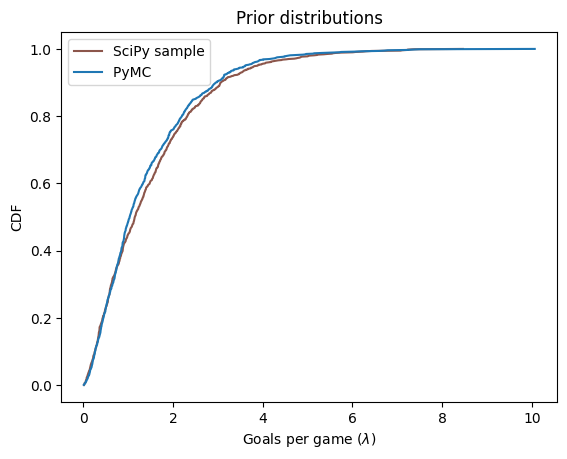

In [25]:
plot_cdf(sample_prior, label='SciPy sample', color='C5')
plot_cdf(sample_prior_pymc, label='PyMC ', color='C0')
plt.legend()
plt.xlabel(r'Goals per game ($\lambda$)')
plt.ylabel('CDF')
plt.title('Prior distributions')

# This suggests that the model specification is correct

In [26]:
# We can also extract goals from the model, and compare to the Poisson object from SciPy

sample_prior_pred_pymc = get_values(idata.prior['goals'])
sample_prior_pred_pymc.shape

(1000,)

In [27]:
# Since the goals are discrete, they can be plotted as step functions rather than CDFs

def plot_pred(sample, **options):
    Cdf.from_seq(sample).step(**options)

Text(0.5, 1.0, 'Prior predictive distributions')

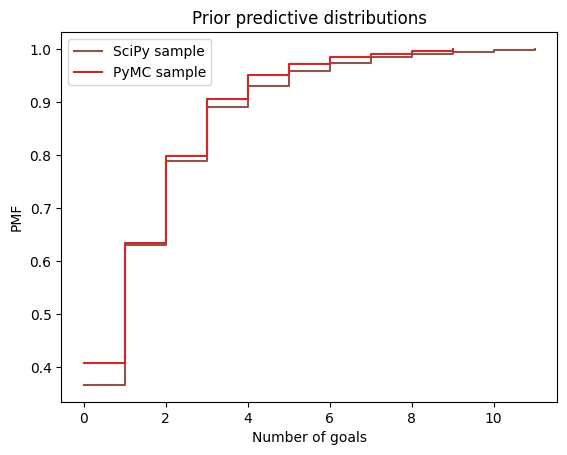

In [28]:
plot_pred(sample_prior_pred, label='SciPy sample', color='C5')
plot_pred(sample_prior_pred_pymc, label='PyMC sample', color='C13')
plt.legend()
plt.xlabel('Number of goals')
plt.ylabel('PMF')
plt.title('Prior predictive distributions')

# Again, pretty close, so we're probably using PyMC correctly

In [29]:
# Before proceeding to inference, we make a small change to the prior predictive model

with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)
    
# And we'll call sample rather than sample_prior_predictive, since we want to sample from the posterior of lam

options = dict()

with model2:
    idata2 = pm.sample(500, **options)

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.80        3            4610.48 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.73        1            2492.22 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.84        1            3160.75 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.10        3            2788.15 draws/s   0:00:00   0:00:00

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [30]:
# Instead of a single Markov chain, PYMC uses multiple chains and compares results to make sure they're consistent
# This analysis produced 2 samples of 1000 each, discarded half of each, and returned 1000 even though we asked for 500

# From idata2 we can sample from the posterior

sample_post_pymc = get_values(idata2.posterior['lam'])

In [31]:
sample_post_pymc.shape

(2000,)

Text(0.5, 1.0, 'Posterior distributions')

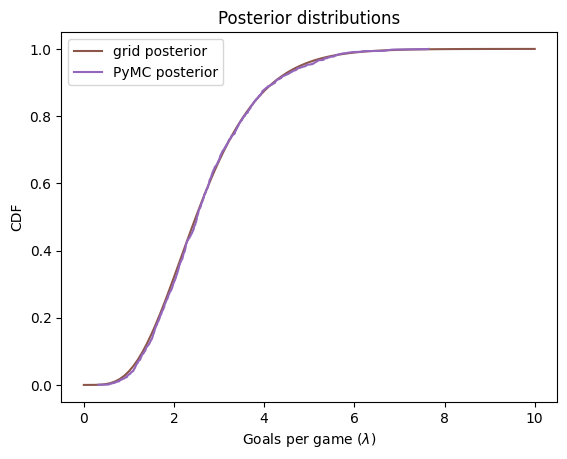

In [32]:
posterior.make_cdf().plot(label='grid posterior', color='C5')
plot_cdf(sample_post_pymc, label='PyMC posterior', color='C4')
plt.legend()
plt.xlabel(r'Goals per game ($\lambda$)')
plt.ylabel('CDF')
plt.title('Posterior distributions')

In [33]:
# To sample from the posterior predictive

with model2:
    idata2_pred = pm.sample_posterior_predictive(idata2)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

In [34]:
sample_post_pred_pymc = get_values(idata2_pred.posterior_predictive['goals'])
sample_post_pred_pymc.shape

(2000,)

In [35]:
# We can also generate a sample from the grid posterior

sample_post = posterior.sample(1000)
sample_post_pred = poisson(sample_post).rvs()

Text(0.5, 1.0, 'Posterior predictive distributions')

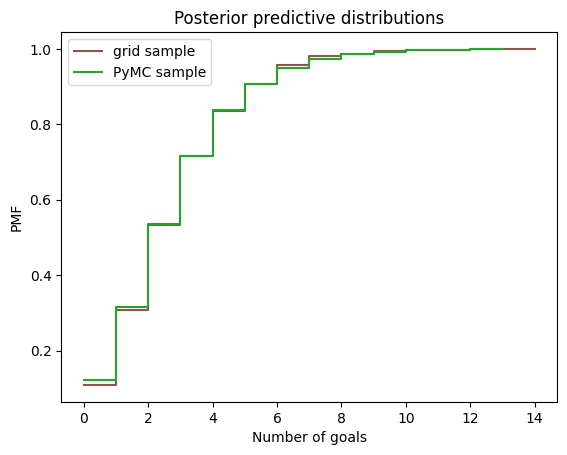

In [36]:
plot_pred(sample_post_pred, label='grid sample', color='C5')
plot_pred(sample_post_pred_pymc, label='PyMC sample', color='C12')
plt.legend()
plt.xlabel('Number of goals')
plt.ylabel('PMF')
plt.title('Posterior predictive distributions')

In [38]:
# The usefulness of MCMC will be clearer with a more complex model

filename = 'WHR20_DataForFigure2.1.xls'
df = pd.read_excel(filename)
df.head(3)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267


In [39]:
df.shape

(153, 20)

In [40]:
# The column 'ladder score' is the score we're predicting

score = df['Ladder score']

In [41]:
# We'll start by looking at the relationship between happiness and income

log_gdp = df['Logged GDP per capita']

Text(0, 0.5, 'Happiness score')

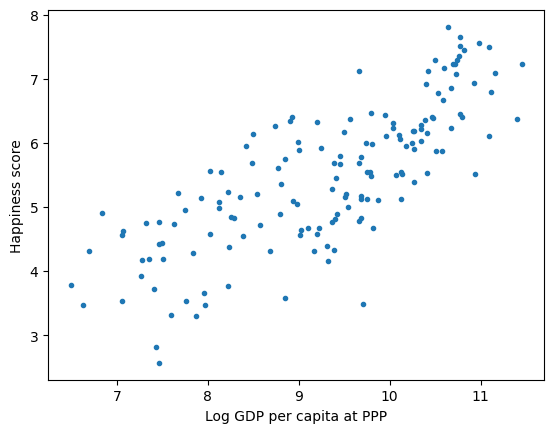

In [42]:
plt.plot(log_gdp, score, '.')
plt.xlabel('Log GDP per capita at PPP')
plt.ylabel('Happiness score')

In [43]:
# SciPy's linregress lets us perform a simple regression

from scipy.stats import linregress

result = linregress(log_gdp, score)

In [44]:
pd.DataFrame([result.slope, result.intercept], index=['Slope', 'Intercept'], columns=[''])

,
Slope,0.717738
Intercept,-1.198646


In [46]:
# Now we'll estimate the same model with PyMC

x_data = log_gdp
y_data = score

with pm.Model() as model3:
    a = pm.Uniform('a', 0, 4) # The ranges of the priors are chosen to be wide enough to cover the posteriors
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)
    
    y_est = a * x_data + b
    y = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_data)

In [47]:
with model3:
    idata3 = pm.sample(500, **options)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.14        11           534.09 draws/s   0:00:02   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.14        31           829.94 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.14        3            531.83 draws/s   0:00:02   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.10        31           784.47 draws/s   0:00:01   0:00:00

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


In [48]:
# The resulting object contains samples from the joint posterior of a, b, and sigma

import arviz as az

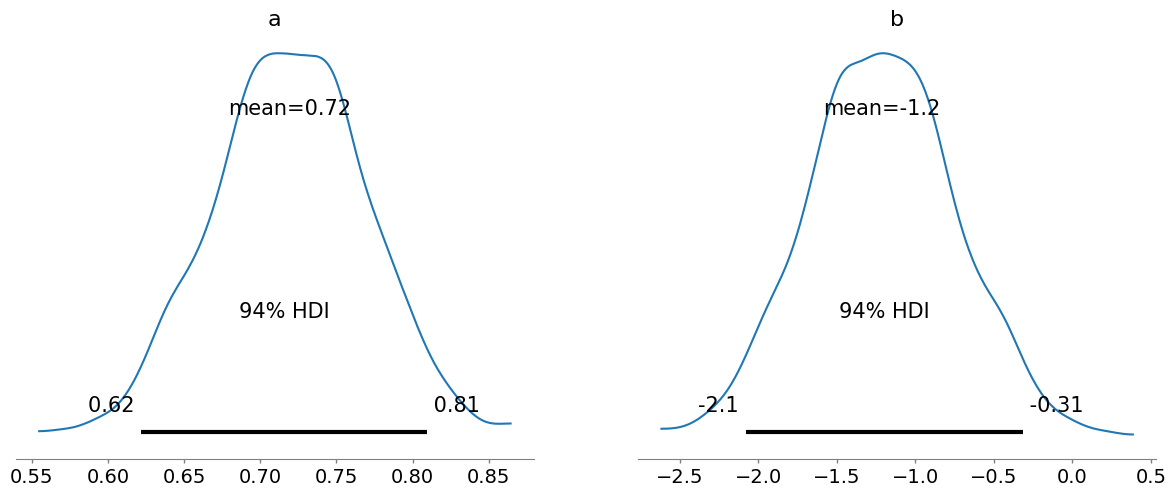

In [49]:
with model3:
    az.plot_posterior(idata3, var_names=['a', 'b']) # KDE estimates of 94% credible intervals

In [50]:
# The MCMC estimates are consistent with what we estimated with linregress

print('Sample mean:', get_values(idata3.posterior['a'].mean()))
print('Regression slope:', result.slope)

Sample mean: [0.71900814]
Regression slope: 0.7177384956304523


In [51]:
print('Sample mean:', get_values(idata3.posterior['b'].mean()))
print('Regression intercept:', result.intercept)

Sample mean: [-1.21036915]
Regression intercept: -1.1986460618088879


<Axes: title={'center': 'x'}>

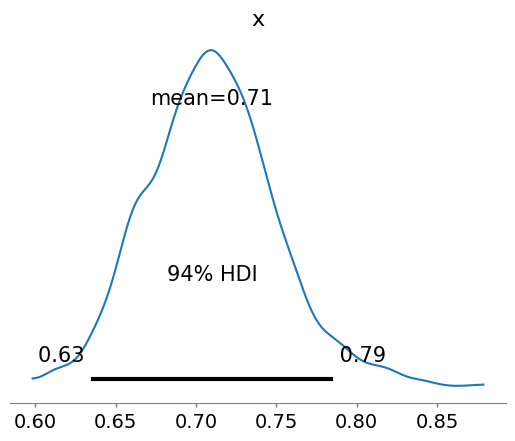

In [52]:
# Marginal posterior of sigma

az.plot_posterior(get_values(idata3.posterior['sigma']))

In [53]:
# The regression model in the happiness report has six predictive variables, which is impractical to estimate by 
# grid approximation (i.e., trillions of likelihoods)

# First the columns we need from the dataframe

columns = ['Ladder score',
          'Logged GDP per capita',
          'Social support',
          'Healthy life expectancy',
          'Freedom to make life choices',
          'Generosity',
          'Perceptions of corruption']

subset = df[columns]
subset.head()

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.8087,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445
1,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
2,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728
3,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710
4,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218


In [54]:
# The variables all have different units, but we can standardize so everything has mean 0 and SD 1

standardized = (subset - subset.mean()) / subset.std()

In [55]:
# Now we extract the variables to build the model

y_data = standardized['Ladder score']
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

In [56]:
with pm.Model() as model4:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)
    
    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_data)
    
with model4:
    idata4 = pm.sample(500, **options)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.40        15           940.61 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.37        7            616.14 draws/s   0:00:02   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.57        7            745.25 draws/s   0:00:02   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.42        15           646.31 draws/s   0:00:02   0:00:00

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


In [57]:
get_values(idata4.posterior['b0']).mean()

-0.0001356323045648321

In [58]:
get_values(idata4.posterior['sigma']).mean()

0.5163119877545385

In [59]:
# We can extract samples from the posteriors of the parameters and compute their means

param_names = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']

means = [get_values(idata4.posterior[name]).mean() for name in param_names]

In [60]:
def credible_interval(sample):
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

In [61]:
cis = [credible_interval(get_values(idata4.posterior[name])) for name in param_names]

In [62]:
# The results are summarized in this table

index = columns[1:]
table = pd.DataFrame(index=index)
table['Posterior mean'] = np.round(means, 3)
table['94% CI'] = cis
table

,Posterior mean,94% CI
Logged GDP per capita,0.248,"[0.083, 0.414]"
Social support,0.295,"[0.155, 0.428]"
Healthy life expectancy,0.224,"[0.063, 0.384]"
Freedom to make life choices,0.191,"[0.092, 0.292]"
Generosity,0.054,"[-0.033, 0.14]"
Perceptions of corruption,-0.099,"[-0.197, 0.003]"


In [63]:
# Ex 19-1. Solving the Euro problem with MCMC
# So, beta prior with alpha = beta = 1 > 140 heads on 250 tosses > what is the posterior distribution of the prob of heads?

# I might need some help with syntax, but I think I get the basic setup

#with pm.Model() as model5:
#    prob_heads = pm.Beta('prob_heads', alpha=1.0, beta=1.0)
#    heads = pm.Binomial('heads', prob_heads, k=140, n=250)
    
#with model5:
#    idata5 = pm.sample(500, **options)
# Almost

n = 250
k_obs = 140

with pm.Model() as model5:
    x = pm.Beta('x', alpha=1.0, beta=1.0)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    
with model5:
    idata5 = pm.sample(500, **options)

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.63        3            4240.04 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.62        3            2820.65 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.73        1            2381.62 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.41        1            2510.62 draws/s   0:00:00   0:00:00

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


<Axes: title={'center': 'x'}>

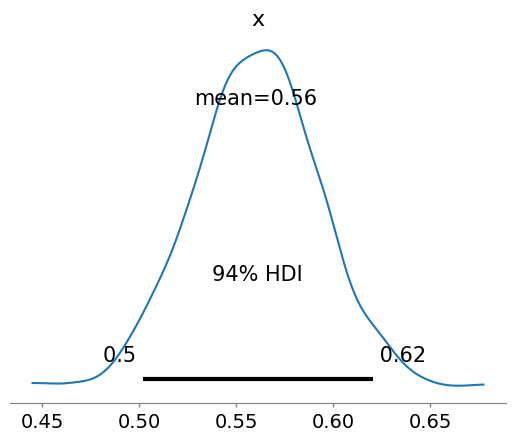

In [64]:
az.plot_posterior(idata5)

In [66]:
# Ex 19-2: The Grizzly Bear problem
# During the 1st tagging session, k=23 bears are tagged
# During the 2nd session, n=19 bears are tagged, x=4 of which had been tagged first
# Estimate the posterior of N (the total number of bears)

k = 23
n = 19
x = 4

with pm.Model() as model6:
    N = pm.DiscreteUniform('N', 50, 500)
    y = pm.HyperGeometric('y', N=N, k=k, n=n, observed=x)
    
with model6:
    idata6 = pm.sample(1000, **options)

 Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    117.13    0.00          5882.97 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    128.84    0.29          4269.90 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    161.05    0.00          4161.66 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    117.13    0.59          3509.84 draws/s   0:00:00   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


<Axes: title={'center': 'N'}>

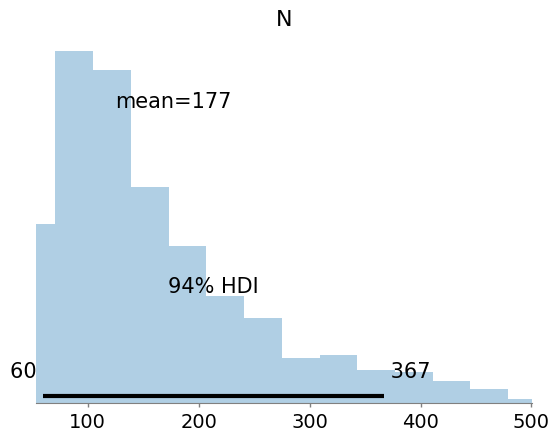

In [67]:
az.plot_posterior(idata6)

In [68]:
# Ex 19-3: Use pymc to sample from a Weibull joint posterior with lambda=3 and k=0.8

from scipy.stats import weibull_min

lam = 3
k = 0.8
actual_dist = weibull_min(k, scale=lam)

data = actual_dist.rvs(10)
data

array([ 2.3263246 ,  1.11069231,  1.018791  ,  6.14273161,  1.51043443,
        0.31943579,  4.02948266,  2.43793493, 10.35345232,  2.78817082])

In [69]:
with pm.Model() as model7:
    lam = pm.Uniform('lam', 0.1, 10.1)
    k = pm.Uniform('k', 0.1, 5.1)
    y = pm.Weibull('y', alpha=k, beta=lam, observed=data)
    
with model7:
    idata7 = pm.sample(1000, **options)

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.87        3            3104.82 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.43        7            1738.53 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.97        7            2362.35 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    4             0.61        1            2143.16 draws/s   0:00:00   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'k'}>],
      dtype=object)

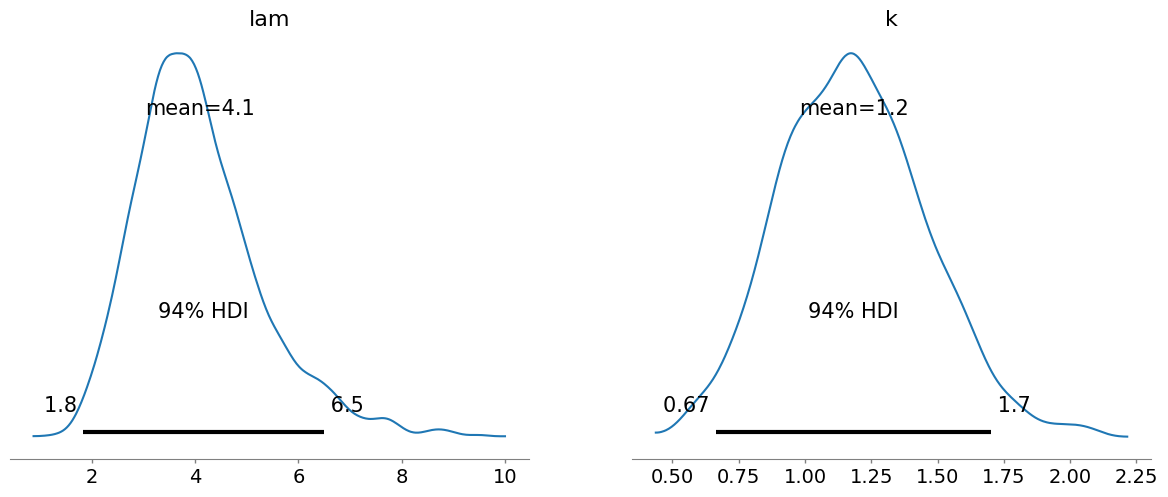

In [70]:
az.plot_posterior(idata7)

In [71]:
# Ex 19-4: Improving reading ability
# Use uniform priors to estimate mu and sigma as parameters of a normal distribution

df = pd.read_csv('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv?raw=true', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [72]:
# Use groupby to separate the treated and control groups

grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']
    
data = responses['Treated']

In [73]:
with pm.Model() as model8:
    mu = pm.Uniform('mu', 20, 80)
    sigma = pm.Uniform('sigma', 5, 30)
    y = pm.Normal('y', mu, sigma, observed=data)
    idata8 = pm.sample(500, **options)

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             0.79        3            1717.29 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.01        3            2633.56 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.08        3            2758.11 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1500    0             1.21        1            1951.28 draws/s   0:00:00   0:00:00

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


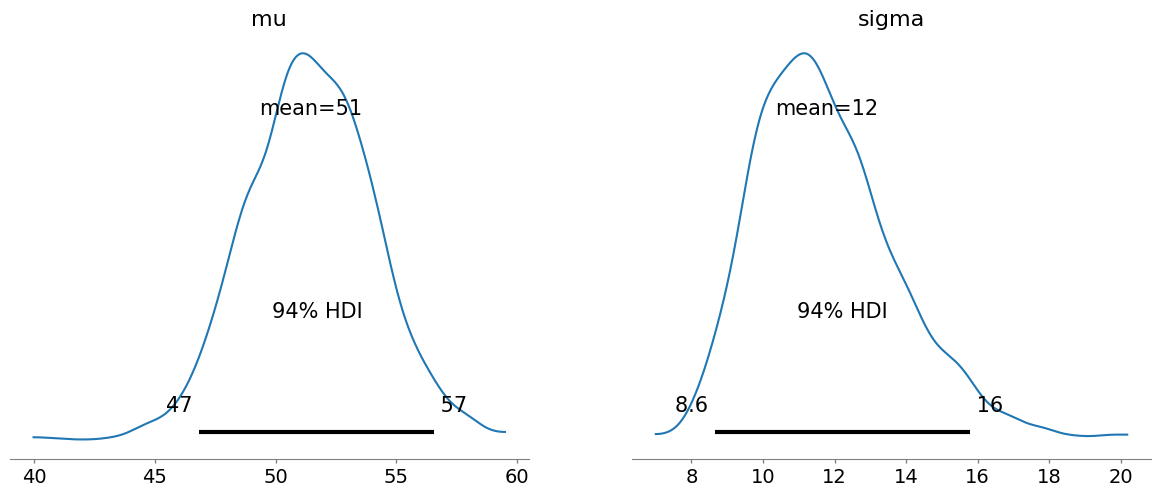

In [74]:
with model8:
    az.plot_posterior(idata8)

In [76]:
# Ex 19-5: the Lincoln Index problem: tester 1 finds 20 bugs, tester 2 finds 15, with 3 in common

# One of the challenges is that we have to estimate k00, which depends on the data

#k00 = N - num_seen

#data = pm.math.stack((k00, k01, k10, k11))

k01 = 15 - 3
k10 = 20 - 3
k11 = 3

num_seen = k01 + k10 + k11
num_seen

32

In [83]:
with pm.Model() as model9:
    p0 = pm.Beta('p0', alpha=1, beta=1)
    p1 = pm.Beta('p1', alpha=1, beta=1)
    N = pm.DiscreteUniform('N', num_seen, 350)
    
    q0 = 1-p0
    q1 = 1-p1
    ps = [q0*q1, q0*p1, p0*q1, p0*p1]
    
    k00 = N - num_seen
    data = pm.math.stack([k00, k01, k10, k11])
    y = pm.Multinomial('y', n=N, p=ps, observed=data) # Pasted from the solution, but throws a mysterious error

TypeError: Variables that depend on other nodes cannot be used for observed data.The data variable was: Cast{int32}.0